In [1]:
import pandas_datareader.data as web
import datetime

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Sets endpoints to fetch data from IEX
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018,1,1)
ticker = 'AAPL'

In [5]:
df = web.DataReader(ticker , 'iex' , start, end)
print(df.tail())

                open      high       low     close    volume
date                                                        
2017-12-22  171.3612  172.0911  171.1846  171.6850  16349444
2017-12-26  167.5549  168.2122  166.4552  167.3293  33185536
2017-12-27  166.8682  167.5353  166.4856  167.3587  21498213
2017-12-28  167.7511  168.5850  167.2410  167.8296  16480187
2017-12-29  167.2803  167.3489  166.0050  166.0148  25999922


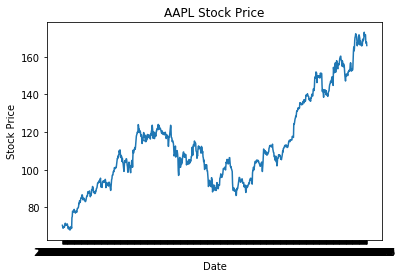

In [8]:
#generates the plot 
plt.title(ticker + " Stock Price")
plt.ylabel("Stock Price")
plt.plot(df['close'])
plt.show()


In [9]:
#Creates a new metric as a 'day price'
df['Mid Price'] = (df['open'] + df['close'])/2

#Splits 80% into train data and 20% into test data
train_size = int(0.8 * len(df))
train_data = df['Mid Price'][:train_size].values
test_data = df['Mid Price'][train_size:].values

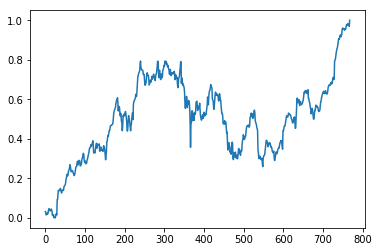

In [10]:
#Uses Min Max Scaler from sklearn pre processing
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

#Reshapes data
train_data = scaler.fit_transform(train_data).reshape(-1)
test_data = scaler.fit_transform(test_data).reshape(-1)
plt.plot(train_data)

In [11]:
#Converts the training data to smoothed EMA
EMA = 0.0
gamma = 0.1
EMA_train_data = [ ]
for x in range(len(train_data)):
    EMA = gamma * train_data[x] +(1-gamma) * EMA
    EMA_train_data.append(EMA)

all_mid_data = np.concatenate([EMA_train_data, test_data], axis=0)

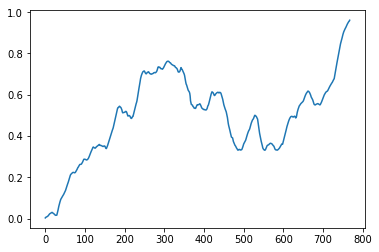

In [12]:
plt.plot(EMA_train_data)

100


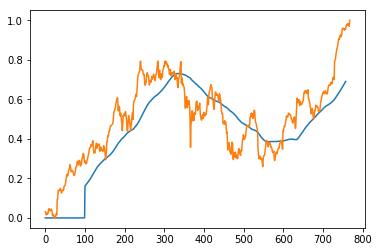

In [13]:
#This was the first attempt, check the rest of the notebook for a more accurate one
avg_train_data = [ ]
for x in range(0, 100):
    avg_train_data.append(0)
    
print(len(avg_train_data))
def calcAvg(start, end, df):
    newdf = df[start:end]
    return np.mean(newdf)


for y in range(len(train_data) - 110):
    avg_train_data.append(calcAvg(y, y+100, train_data))

plt.plot(avg_train_data)
plt.plot(train_data)

In [1]:
"""
Example Code from online
#Forecasting 1 day in the future with EMA
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))
plt.figure(figsize=(18,9))
plt.plot(run_avg_predictions, color='orange', label='Predictions')
plt.plot(train_data, color='green', label='Actual')
plt.legend()
"""

"\nExample Code from online\n#Forecasting 1 day in the future with EMA\nwindow_size = 100\nN = train_data.size\n\nrun_avg_predictions = []\nrun_avg_x = []\n\nmse_errors = []\n\nrunning_mean = 0.0\nrun_avg_predictions.append(running_mean)\n\ndecay = 0.5\n\nfor pred_idx in range(1,N):\n\n    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]\n    run_avg_predictions.append(running_mean)\n    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)\n\nprint('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))\nplt.figure(figsize=(18,9))\nplt.plot(run_avg_predictions, color='orange', label='Predictions')\nplt.plot(train_data, color='green', label='Actual')\nplt.legend()\n"

In [15]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018,1,1)
ticker = 'AAPL'
newdata = web.DataReader(ticker , 'iex' , start, end)
print(len(newdata))

960


In [16]:
newdata['Mid Price'] = (newdata['open'] + newdata['close'])/2
x_var = newdata['Mid Price']

In [17]:
newscaler = MinMaxScaler()
x_var = x_var.values

In [18]:
x_var = x_var.reshape(-1,1)
x_var = newscaler.fit_transform(x_var).reshape(-1)

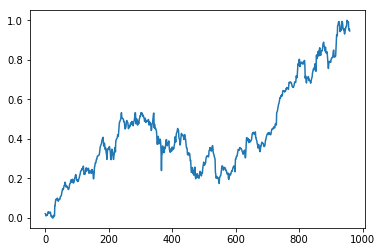

In [19]:
plt.plot(x_var)

In [20]:
#In a sequence of A+B days, the first A are used to train and then predict the next B
A = 5
B = 2
period = A + B

input_var = [ ]
output_var = [ ]

for x in range(int(len(x_var)/(period))):
    currentList = [ ]
    for y in range(A):
        currentList.append(x_var[period*x + y])
    input_var.append(currentList)
    
    currentList = [ ]
    for z in range(B):
        currentList.append(x_var[period * x + z+y+1])
    output_var.append(currentList)



In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split



Using TensorFlow backend.


In [22]:
import pandas as pds
input_var = pds.DataFrame(input_var)
output_var = pds.DataFrame(output_var)

X_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size = 0.2, random_state = 11)


print("Done")

Done


In [23]:
import numpy as np
#Reshapes the numpy array into the following format which the LSTM requires:
#(Reshape into samples, timesteps per sample, features(1))
X_train = np.array(X_train)
x_test = np.array(x_test)

X_train = X_train.reshape(len(X_train), A, 1)
x_test = x_test.reshape(len(x_test), A, 1)
print("Reshaped both")

Reshaped both


In [24]:
#Neural Network, 5(A) inputs -> 3 neurons (Hidden layer) -> 2(B) outputs

model = Sequential()
model.add(LSTM(3, input_shape = (5, 1), kernel_initializer = 'random_normal'))
model.add(Dropout(0.2))
model.add(Dense(2, kernel_initializer = 'random_normal', activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss = 'mean_squared_error', optimizer ='adam', metrics =['accuracy'])

In [26]:
model.fit(X_train, y_train, epochs = 200)

Epoch 1/200
109/109 [==============================] - 1s 8ms/step - loss: 0.2375 - acc: 0.5963
Epoch 2/200
109/109 [==============================] - 0s 334us/step - loss: 0.2340 - acc: 0.5963
Epoch 3/200
109/109 [==============================] - 0s 308us/step - loss: 0.2304 - acc: 0.4587
Epoch 4/200
109/109 [==============================] - 0s 352us/step - loss: 0.2267 - acc: 0.4037
Epoch 5/200
109/109 [==============================] - 0s 343us/step - loss: 0.2228 - acc: 0.4220
Epoch 6/200
109/109 [==============================] - 0s 318us/step - loss: 0.2192 - acc: 0.4862
Epoch 7/200
109/109 [==============================] - 0s 317us/step - loss: 0.2153 - acc: 0.4220
Epoch 8/200
109/109 [==============================] - 0s 318us/step - loss: 0.2117 - acc: 0.4220
Epoch 9/200
109/109 [==============================] - 0s 326us/step - loss: 0.2074 - acc: 0.4587
Epoch 10/200
109/109 [==============================] - 0s 328us/step - loss: 0.2032 - acc: 0.4037
Epoch 11/200
109/109 

109/109 [==============================] - 0s 330us/step - loss: 0.0121 - acc: 0.5229
Epoch 165/200
109/109 [==============================] - 0s 320us/step - loss: 0.0099 - acc: 0.5321
Epoch 166/200
109/109 [==============================] - 0s 310us/step - loss: 0.0078 - acc: 0.5505
Epoch 167/200
109/109 [==============================] - 0s 338us/step - loss: 0.0109 - acc: 0.5505
Epoch 168/200
109/109 [==============================] - 0s 341us/step - loss: 0.0066 - acc: 0.5413
Epoch 169/200
109/109 [==============================] - 0s 311us/step - loss: 0.0081 - acc: 0.5688
Epoch 170/200
109/109 [==============================] - 0s 326us/step - loss: 0.0092 - acc: 0.5505
Epoch 171/200
109/109 [==============================] - 0s 343us/step - loss: 0.0087 - acc: 0.5596
Epoch 172/200
109/109 [==============================] - 0s 341us/step - loss: 0.0082 - acc: 0.5963
Epoch 173/200
109/109 [==============================] - 0s 333us/step - loss: 0.0118 - acc: 0.5688
Epoch 174/200


676


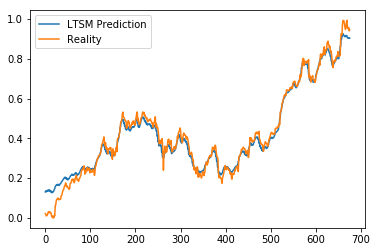

In [27]:
predictionArray = [ ]
currentArray = [ ]
reality = [ ]
newinput = np.array(input_var)
newinput = newinput.reshape(-1)
for x in range(0, len(newinput) -10, B):
    currentArray = newinput[x:x+A]
    currentArray = currentArray.reshape(1,A,1)
    vals = model.predict(currentArray)
    #the number of days in the future we are forecasting out
    for z in range(0, B):
        reality.append(newinput[x+z])
        predictionArray.append(vals[0][z])


        
print(len(predictionArray))
plt.plot(predictionArray, label='LTSM Prediction')
plt.plot(reality, label ='Reality')
plt.legend()


